1) To Perform single camera calibration using either a chessboard or circular pattern.


Steps:
1. Collecting 50+ images of chessboard.
2. Save images in google drive.

Google Drive for chessboard images: https://drive.google.com/drive/folders/1KJ6g2TDppQQARRozyvTsvavK7jSffIIL?usp=sharing

Steps Involved:
A) Paramter Initialization :
1. Square Chessboard Size: 10,7 - (10 squares by 7 squares)
2. frame_size is defined as (640, 480), which is the size of the image frames (in pixels).
3. criteria defines the termination criteria for corner refinement using cv2.cornerSubPix().This combines conditions of maximum iterations (30 iterations) or achieving a minimum accuracy (0.001). cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER is used in OpenCV to set the termination criteria for iterative algorithms.     

 3a) cv2.TERM_CRITERIA_EPS: This flag stands for "epsilon," which is the desired accuracy or change in the parameters at which the iterative algorithm stops. Essentially, it tells the algorithm to stop when it has reached a sufficiently small error threshold, which is defined by the third element in the criteria tuple.

 3b) cv2.TERM_CRITERIA_MAX_ITER: This flag indicates that the algorithm should stop after a maximum number of iterations. This number is defined by the second element of the criteria tuple. This is a safeguard against the possibility that the algorithm might not converge to a solution quickly.

4. size_of_chessboard_square is 20 mm, specifying the size of each square on the chessboard

B) Object Points :
1. obj_p is initialized as a zero array with shape (number of corners, 3) where the number of corners is chessboard_size[0] * chessboard_size[1] (i.e., 70 corners), and 3 for the x, y, z coordinates in 3D space.
2. Using numpy.mgrid, a meshgrid is created for x and y coordinates, which is then reshaped and multiplied by size_of_chessboard_square to scale the grid points according to the real size of the chessboard squares.

C) List for Storing Points :
1. objpts and imgpts are lists for storing object and image points.

D) Loading images
1. using cv2.imread() to load all the images that are required.

E) Iterating over Each Image:
1. Loop Over Each Image: For each image filename in images, the image is loaded in grayscale. Chessboard corners (corners) are attempted to be found in the image using cv2.findChessboardCorners().
2. If corners are found (ret is true):The object points (obj_p) are added to objpts. The image points are refined using cv2.cornerSubPix() and added to imgpts.

F) Camera Calibration:
1. If both objpts and imgpts are non-empty, cv2.calibrateCamera() is done to compute the camera matrix, distortion coefficients, rotation and translation vectors.
2. If the calibration is successful:The reprojection errors are calculated for each image using the Euclidean distance between the observed corners (imgpts) and the projected points using the camera parameters.

G) Undistorting the Image and Visualization of original, reprojected points on undistorted image and the re-projection error graph
1.  An image is selected, read and its size is determined.
2.  A new camera matrix optimized for the undistorted image is calculated using cv2.getOptimalNewCameraMatrix().
3.  The image is undistorted using cv2.undistort() with the original and the new camera matrices. The original and undistorted images are converted to RGB and visualized with the detected and reprojected points marked.
4. Plots are created to show the detected corners on the original image and the reprojected points on the undistorted image using matplotlib.

H) Error Analysis:
1. A plot of reprojection errors across all images is generated to evaluate the quality of the calibration.

In [1]:
# import matplotlib
# matplotlib.use('TkAgg')

import numpy as np                                          #importing numpy library for data manipulation
import pandas as pd                                         #importing pandas library for reading files and manipulation
import matplotlib.pyplot as plt                             #importing matplotlib  for plotting graphs
import cv2                                                  #importing opencv for image processing
import glob                                                 #importing glob for reading files
import pickle                                               #importing pickle for saving and loading files
import re                                                   #importing re for regular expressions
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Calibration was successful.


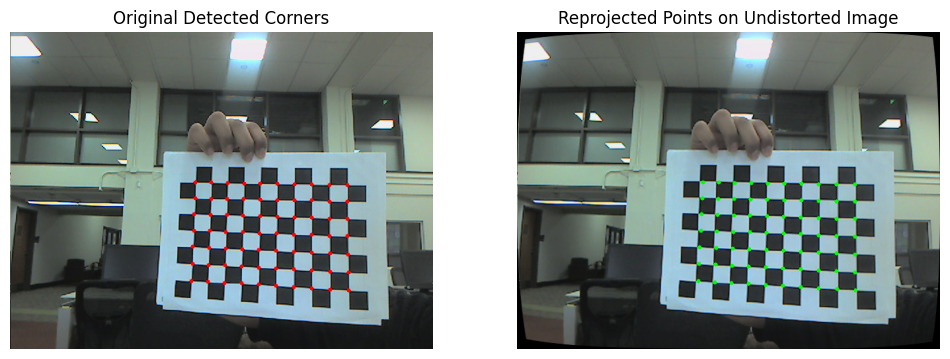

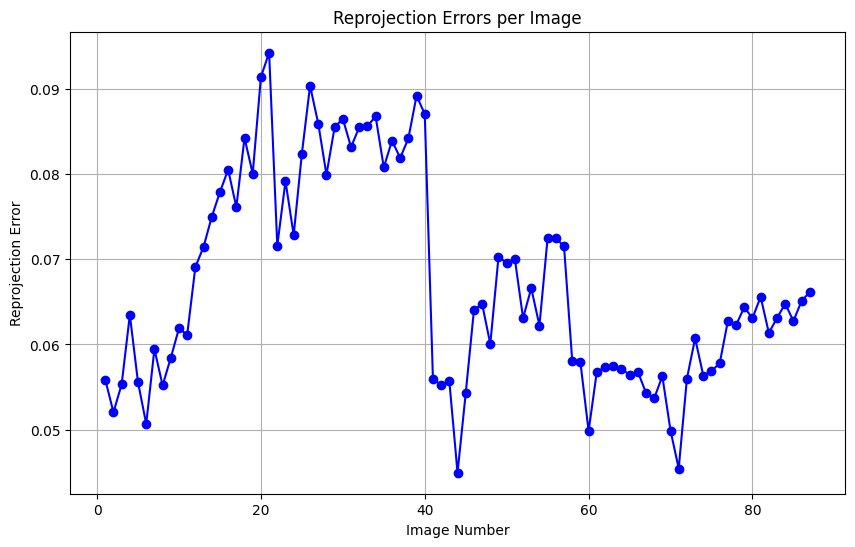

In [ ]:
"""
    Calibrate the camera using the chessboard images.
    1. Load the images.
    2. Find the chessboard corners.
    3. Calibrate the camera.
    4. Calculate the reprojection error.
    5. Undistort the images.
    6. Reproject the points on the undistorted images.
    7. Display the results.
    Args:
    chessboard_size: Tuple of the number of inner corners in the chessboard.
    frame_size: Tuple of the size of the frame.
    criteria: Criteria for the subpixel corner detection.
    size_of_chessboard_square: Size of the chessboard square in mm.
    obj_p: 3D points of the chessboard corners.
    objpts: 3D points of the chessboard corners for all images.
    imgpts: 2D points of the chessboard corners for all images.
    images: List of chessboard images.
    fname: File name of the image.
    ret: Return value of the findChessboardCorners function.
    cameraMatrix: Camera matrix.
    dist: Distortion coefficients.
    rvecs: Rotation vectors.
    tvecs: Translation vectors.
    newCameraMatrix: New camera matrix.
    roi: Region of interest.
    undistorted_img: Undistorted image.
"""
chessboard_size = (10, 7)                                                                                         #size of the chessboard
frame_size = (640, 480)                                                                                           #size of the frame
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)                                        #criteria for subpixel corner detection
size_of_chessboard_square = 20                                                                                    #size of the chessboard square in mm

obj_p = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)                                        #3D points of the chessboard corners
obj_p[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * size_of_chessboard_square  #3D points of the chessboard corners

objpts = []                                                                                                       #3D points of the chessboard corners for all images
imgpts = []                                                                                                       #2D points of the chessboard corners for all images


images = glob.glob('/content/drive/MyDrive/ENPM673/images/*.png')                            #loading images from the folder
if not images:
    print("Error: No images found.")
    exit()

for fname in images:                                                                                              #iterating through the images
    img = cv2.imread(fname)                                                                                       #reading the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                                                                  #converting the image to grayscale
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)                                         #finding the chessboard corners
    if ret:
        objpts.append(obj_p)                                                                                      #appending the 3D points of the chessboard corners
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)                                  #subpixel corner detection
        imgpts.append(corners2)                                                                                   #appending the 2D points of the chessboard corners

if objpts and imgpts:                                                                                             #if points are detected
    ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, frame_size, None, None)           #calibrating the camera using the rteurned points
    if ret:
        print("Calibration was successful.")                                                                      #printing the success message
        errors = []

        for i in range(len(objpts)):                                                                              #iterating through the points
            imgpts2, _ = cv2.projectPoints(objpts[i], rvecs[i], tvecs[i], cameraMatrix, dist)                     #projecting the points
            error = cv2.norm(imgpts[i], imgpts2, cv2.NORM_L2) / len(imgpts2)                                      #calculating the error using norm and L2 Norm
            errors.append(error)                                                                                  #appending the error


        image_index = 0                                                                                           #index of the image
        original_img = cv2.imread(images[image_index])                                                            #reading the image
        h, w = original_img.shape[:2]                                                                             #getting the shape of the image


        newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w, h), 1, (w, h))               #getting the new camera matrix
        undistorted_img = cv2.undistort(original_img, cameraMatrix, dist, None, newCameraMatrix)                  #undistorting the image

        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)                                          #converting the original image to RGB for plotting using matplotlib
        undistorted_img_rgb = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)                                    #converting the undistorted image to RGB for plotting using matplotlib
        reprojected_points, _ = cv2.projectPoints(objpts[image_index], rvecs[image_index], tvecs[image_index], cameraMatrix, dist) #reprojecting the points

        for corner in imgpts[image_index]:                                                                        #iterating through the image points
            cv2.circle(original_img_rgb, tuple(int(i) for i in corner.ravel()), 3, (255, 0, 0), -1)               #drawing a circle on the corners of sqaures of the original image

        for rp in reprojected_points:                                                                             #iterating through the reprojected points
            cv2.circle(undistorted_img_rgb, tuple(int(i) for i in rp.ravel()), 3, (0, 255, 0), -1)                #drawing a circle on the reprojected points of the undistorted image

        plt.figure(figsize=(12, 6))                                                                               #plotting the images
        plt.subplot(1, 2, 1)                                                                                      #plotting the original image
        plt.imshow(original_img_rgb)                                                                              #displaying the original image
        plt.title('Original Detected Corners')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(undistorted_img_rgb)                                                                           #displaying the undistorted image
        plt.title('Reprojected Points on Undistorted Image')
        plt.axis('off')


        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(errors) + 1), errors, marker='o', linestyle='-', color='b')                         #plotting the errors
        plt.title('Reprojection Errors per Image')
        plt.xlabel('Image Number')
        plt.ylabel('Reprojection Error')
        plt.grid(True)

        plt.show()

    else:
        print("Calibration failed.")
else:
    print("No points detected, calibration failed.")


Google drive for classroom images: https://drive.google.com/drive/folders/1AASQpRO7ydUf0n385rDDeTGEsTAjZPzl?usp=sharing

Google drive for traproom images:https://drive.google.com/drive/folders/1rOm3F5eAp1WWNoo26IDZ1R2abr6jRcxy?usp=sharing

Google drive for storageroom images:https://drive.google.com/drive/folders/1dqWdCPwDhMC86DqYyZvfrwSe-0pkJa68?usp=sharing




Pipeline for Creating a Stereo Vision System:

Each containing two images of the same scene captured from different camera
perspectives. Each dataset includes a calib.txt file detailing camera matrices, baseline, image size, and other parameters
necessary for calibration and stereo vision.


CALIBRATION:

a. Identify matching features between the two images in each dataset using any feature matching algorithms.

b. Estimate the Fundamental matrix using RANSAC method based on the matched features.

c. Compute the Essential matrix from the Fundamental matrix considering calibration parameters.

d. Decompose the Essential matrix into rotation and translation matrices.

Steps Involved:

A) Reading Images
1. Using cv2.imread() function img1 and img2 are read.
2. img1 and img2 are converted to gray scale.

B) Extraction of Feature Points
1. Using SIFT, we extract the keypoints and descriptions of both images
2. Using Brute-Force Matcher, we match the description of both images
cv2.BFMatcher() creates a brute-force matcher object which will match descriptors from two images based on a distance calculation.
bf.knnMatch() finds the k best matches for each descriptor from des1 in des2 (in this case, k=2). This function returns the two best matches for each feature point.

C) Good Matches
1.The matches are iterated over, and the good ones are selected based on the distance attribute. A match is considered good if the distance of the first match (m) is less than 0.8 times the distance of the second match (n). This helps in filtering out weak matches.

D) Drawing Matches
1. cv2.drawMatchesKnn(): This function draws the good matches on a new image matched_image that places the images side by side. Only those matches that pass the filter are drawn.

E) Points for Fundamental Matrix
1. List of Points:Points corresponding to the good matches are extracted again (this seems redundant and could use the earlier good_matches).The keypoints for matched features (pts1 from img1_g and pts2 from img2_g) are stored.
2. Conversion to NumPy Arrays: The lists of points are converted to NumPy arrays (p1 and p2) to facilitate further calculations using OpenCV functions.

F) Fundamental Matrix Calculation
1. cv2.findFundamentalMat():Computes the fundamental matrix F which describes the epipolar geometry between two views. It uses the RANSAC algorithm (cv2.FM_RANSAC) to robustly estimate the matrix using the matched points.

G) Reading the Calibration Text file
1. Pulling the essential values from the calibration file, and parameters camera matrix K (intrinsic parameters) are extracted.

H) Essential Matrix Calculation
1. Calculated as E = K.T @ F @ K, where @ denotes matrix multiplication. The essential matrix relates corresponding points in stereo images assuming normalized coordinates.

I) Recovering the Pose
1. cv2.recoverPose(): Estimates the pose of the second camera relative to the first camera (R, T - rotation and translation matrices respectively) when given the essential matrix and the matched points. This function also returns a mask that indicates inlier points which fit the model well.

J) Printing
1. Printing the Fundamental Matrix
2. Printing the Camera Matrix
3. Printing the Essential Matrix
4. Printing the Rotational Matrix
5. Printing the Tranlational Matrix

## IN ORDER TO RUN THE CODE ON ALL THE THREE REQUIRED FILES:

---
### Change the files based on reading the images,
1. classroom
1. traproom
3. storageroom


---
### Then change the calib.txt file in this block

---

### Then goto the last cell block which will have SGBM and change the image saving function to write the image with corresponding png format.


In [30]:
"""
This reads the images and calculates the Fundamental matrix using RANSAC.
Steps:
1. Read the images.
2. Detect the keypoints and descriptors.
3. Match the keypoints using the BFMatcher.
4. Find the good matches.
5. Draw the matches.
6. Find the Fundamental matrix using RANSAC.
7. Recover the pose.
8. Display the results.
Args:
img1: First image.
img2: Second image.
sift: SIFT object.
key1: Keypoints of the first image.
des1: Descriptors of the first image.
key2: Keypoints of the second image.
des2: Descriptors of the second image.
bf: BFMatcher object.
matches: Matches between the keypoints.
good_matches: Good matches between the keypoints.
matched_image: Image with the matches.
pts1: Points of the first image.
pts2: Points of the second image.
p1: Points of the first image as NumPy array.
p2: Points of the second image as NumPy array.
F: Fundamental matrix.
params: Camera parameters.
calib_file: Calibration file.
K: Camera matrix.
E: Essential matrix.
retval: Return value of the recoverPose function.
R: Rotation matrix.
T: Translation matrix.
mask: Mask for the findFundamentalMat function.
"""

# img1 = cv2.imread('/content/drive/MyDrive/storageroom/im0.png')                                                                            #reading the first image
# img2 = cv2.imread('/content/drive/MyDrive/storageroom/im1.png')                                                                            #reading the second image

# img1 = cv2.imread('/content/drive/MyDrive/classroom/im0.png')                                                                            #reading the first image
# img2 = cv2.imread('/content/drive/MyDrive/classroom/im1.png')                                                                            #reading the second image

img1 = cv2.imread('/content/drive/MyDrive/traproom/im0.png')                                                                            #reading the first image
img2 = cv2.imread('/content/drive/MyDrive/traproom/im1.png')                                                                            #reading the second image

img1_g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()                                                                                            #creating the SIFT object
key1, des1 = sift.detectAndCompute(img1_g, None)                                                                    #detecting and computing the keypoints and descriptors
key2, des2 = sift.detectAndCompute(img2_g, None)                                                                    #detecting and computing the keypoints and descriptors
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8* n.distance:
        good_matches.append(m)                                                                                      #appending the good matches

knn_good_matches = [[m] for m in good_matches]
matched_image = cv2.drawMatchesKnn(img1_g, key1, img2_g, key2, knn_good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) #drawing the matches

pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):                                                              #iterating through the matches
    if m.distance < 0.8 * n.distance:                                                             #if the distance is less than 0.8 times the next distance
        pts2.append(key2[m.trainIdx].pt)                                                          #appending the points
        pts1.append(key1[m.queryIdx].pt)                                                          #appending the points

p1 = np.array(pts1, dtype=np.float32)                                                             #converting the points to NumPy array
p2 = np.array(pts2, dtype=np.float32)
F, mask = cv2.findFundamentalMat(p1, p2, cv2.FM_RANSAC)                                           #finding the Fundamental matrix using RANSAC

params = {}
# calib_file = '/content/drive/MyDrive/storageroom/calib.txt'
# calib_file = '/content/drive/MyDrive/classroom/calib.txt'
calib_file = '/content/drive/MyDrive/traproom/calib.txt'
with open (calib_file, 'r') as file:                                                               #reading the calibration file
  for line in file:
    key,value = line.split('=')
    key = key.strip()
    value = value.strip()
    if '[' in value:
        matrix_data = re.sub(r'[\[\];]', '', value).split()
        matrix = np.array(matrix_data, dtype=np.float32).reshape(-1,3)
        params[key] = matrix
    else:
          if '.' in value or 'e' in value.lower():
            params[key] = float(value)
          else:
            params[key] = int(value)

K = params['cam0']                                                                               #getting the camera matrix

E = K.T @ F @ K                                                                                  #calculating the Essential matrix
retval, R, T, mask = cv2.recoverPose(E, p1, p2, K)                                               #recovering the pose
print(f"----------FUNDAMENTAL MATRIX USING RANSAC-------------------------\n"
      f"Fundamental Matrix using RANSAC F:\n{F}\n"
      f"------------------------------------------------------------------\n"
      f"--------------CAMERA MATRIX---------------------\n"
      f"Camera Matrix:\n{K}\n"
      f"------------------------------------------------------------------\n"
      f"----------- ESSENTIAL MATRIX-------------------\n"
      f"Essential Matrix E:\n{E}\n"
      f"------------------------------------------------------------------\n"
      f"------------ROTATION MATRIX---------------------\n"
      f"Rotation Matrix R:\n{R}\n"
      f"------------------------------------------------------------------\n"
      f"--------- TRANSLATION MATRIX-----------------\n"
      f"Translation Matrix T:\n{T}\n"
      f"------------------------------------------------------------------")

----------FUNDAMENTAL MATRIX USING RANSAC-------------------------
Fundamental Matrix using RANSAC F:
[[ 1.38332971e-07  5.29083090e-04 -2.20762160e-01]
 [-5.36369069e-04  3.45685468e-05 -1.25661955e+01]
 [ 2.27529684e-01  1.25738339e+01  1.00000000e+00]]
------------------------------------------------------------------
--------------CAMERA MATRIX---------------------
Camera Matrix:
[[1.76902e+03 0.00000e+00 1.27189e+03]
 [0.00000e+00 1.76902e+03 5.27170e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
------------------------------------------------------------------
----------- ESSENTIAL MATRIX-------------------
Essential Matrix E:
[[ 4.32903603e-01  1.65572946e+03  1.03187836e+02]
 [-1.67853044e+03  1.08179911e+02 -2.34044435e+04]
 [-9.73881698e+01  2.34660381e+04  1.85797014e+01]]
------------------------------------------------------------------
------------ROTATION MATRIX---------------------
Rotation Matrix R:
[[ 9.99999309e-01 -3.35749442e-04 -1.12673982e-03]
 [ 3.38773393e-04  9

RECTIFICATION

a. Apply perspective transformation to rectify images and ensure horizontal epipolar lines.

b. Print the homography matrices (H1 and H2) for rectification.

c. Visualize epipolar lines and feature points on both rectified images.

Steps Involved:

A) drawlines() function:
1. The functions takes the images, epipolar lines and the points as parameters

B) Gray Scale Image CHeck
1.Checking if img1 and img2 are grayscale (i.e., if they have 2 dimensions). If they are, they are converted to color images (BGR color space) using cv2.cvtColor() with the flags cv2.COLOR_GRAY2BGR. This conversion is necessary to display colored lines and points on the images.

C) Retrieve Dimensions
1. Retrieveing the number of rows and columns (r and c). These are used to define the line endpoints that will be drawn.

D) Loop Over Each Line and Corresponding Points
1. Iterates over each provided epipolar line (r), and the corresponding points (pt1 in img1 and pt2 in img2).

E) Endpoints Calculation
1. For each line represented as r = [a, b, c] in the line equation ax + by + c = 0, we calculate the endpoints.These endpoints define the line to be drawn across the entire width of the image.

F) Draw Epipolar Lines and Corresponding features represented by circles
1. cv2.line() to draw a line between (x0, y0) and (x1, y1) in img1 with green color (0,255,0) and a thickness of 1 pixel.
2. circle at pt1 on img1 using cv2.circle(). then draw a circle at pt2 on img2 with the same specifications as for pt1.


In [31]:
"""
This function draws the epipolar lines on the images.

Args:
img1: First image.
img2: Second image.
lines: Epipolar lines.
p1: Points of the first image.
p2: Points of the second image.
Returns:
img1: First image with epipolar lines.
img2: Second image with epipolar lines.
"""


def drawlines(img1, img2, lines, p1, p2):
    if len(img1.shape) == 2:                                                                           #if the image is grayscale
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)                                                  #convert the image to BGR
    if len(img2.shape) == 2:                                                                           #if the image is grayscale
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)                                                  #convert the image to BGR
    r, c = img1.shape[:2]                                                                              #get the shape of the image rows and columns
    for r, pt1, pt2 in zip(lines, p1, p2):                                                             #iterating through the lines
        x0, y0 = map(int, [0, -r[2] / r[1]])                                                           #mapping the points x0 and y0
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])                                              #mapping the points x1 and y1
        pt1 = (int(pt1[0]), int(pt1[1]))                                                               #converting the points to integer
        pt2 = (int(pt2[0]), int(pt2[1]))                                                               #converting the points to integer
        img1 = cv2.line(img1, (x0, y0), (x1, y1), (0,255,0), 1)                                        #drawing the line on the image1
        img1 = cv2.circle(img1, pt1, 5, (0,0,255), -1)                                                 #drawing a circle on the image1
        img2 = cv2.circle(img2, pt2, 5, (0,0,255), -1)                                                 #drawing a circle on the image2
    return img1, img2                                                                                  #returning the images

A) Conversion of Points:

1. Converting p1 into an integer
2. Converting p2 into an integer

B) Copying image for further processing

C) Calculating the Homography Matrix1 , Homography Matrix2 and returnvalue
1. cv2.stereoRectifyUncalibrated(): Attempts to compute the rectification transforms (homography matrices H1 and H2) for each image.

D) Warping the Images

1. img1_rectified = cv2.warpPerspective(img1_c, H1, (img1_c.shape[1], img1_c.shape[0])): Applies the homography H1 to img1_c.

2. cv2.warpPerspective(), which performs a perspective warp on the image, transforming it so that the pairs of points (p1 and p2) lie on corresponding horizontal lines img2_rectified = cv2.warpPerspective(img2_c, H2, (img2_c.shape[1], img2_c.shape[0])): Similarly applies H2 to img2_c.

In [32]:
"""
Homography Matrix Calculation
Args:
p1: Points of the first image.
p2: Points of the second image.
retval: Return value of the stereoRectifyUncalibrated function.
H1: Homography matrix for the first image.
H2: Homography matrix for the second image.
img1_rectified: Rectified image 1.
img2_rectified: Rectified image 2.
"""


p1 = np.int32(p1)                                                                        #converting the points to integer
p2 = np.int32(p2)                                                                        #converting the points to integer

img1_c = img1.copy()                                                                     #copying the image
img2_c = img2.copy()                                                                     #copying the image

retval, H1, H2 = cv2.stereoRectifyUncalibrated(p1, p2, F, img1_c.shape[1::-1])           #calculating the Homography matrix

img1_rectified = cv2.warpPerspective(img1_c, H1, (img1_c.shape[1], img1_c.shape[0]))     #warping the perspective H1 and img1_c
img2_rectified = cv2.warpPerspective(img2_c, H2, (img2_c.shape[1], img2_c.shape[0]))     #warping the perspective H2 and img2_c
img1_r = img1_rectified.copy()
img2_r = img2_rectified.copy()

print("Homography Matrix 1:\n", H1)                                                      #printing H1 and H2
print("Homography Matrix 2:\n", H2)

Homography Matrix 1:
 [[ 1.26528064e+01 -2.44518999e-01 -7.37574596e+02]
 [ 2.18860982e-01  1.25775361e+01 -2.03423480e+02]
 [ 5.15634401e-04 -3.07266399e-05  1.20793575e+01]]
Homography Matrix 2:
 [[ 1.03877066e+00  5.11703288e-03 -3.99830321e+01]
 [ 1.68893344e-02  1.00009533e+00 -1.62652395e+01]
 [ 4.03987433e-05  1.99006100e-07  9.61109743e-01]]


Steps Involved

A) Epipolarlines Computation for p1 and p2
1. cv2.computeCorrespondEpilines(p2.reshape(-1, 1, 2), 2, F): calculates the epipolar lines for points in p2 (which correspond to points in img2) that should be drawn on img1. The points p2 are reshaped to fit the function's required input shape (−1,1,2)(−1,1,2), where 2 corresponds to the x and y coordinates.

B) passing the images to the drawlines function for p1 and p2

C) Epipolarlines Computation for p2 and p1
1. cv2.computeCorrespondEpilines(p1.reshape(-1, 1, 2), 1, F): Similarly, this calculates the epipolar lines for points in p1 (from img1) that should be drawn on img2. The second argument 1 indicates that the points are from the first image (img1). lines2 = lines2.reshape(-1, 3): Reshapes the output to a suitable format for drawing.

D) passing the images to the drawlines function for p2 and p1


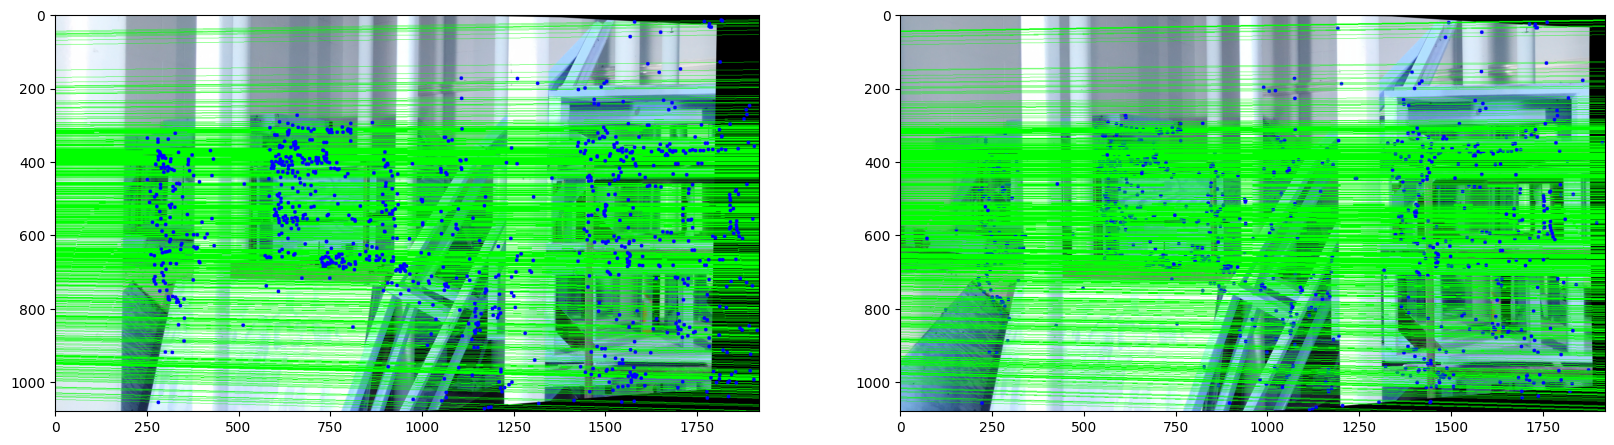

In [33]:
"""
Drawing the Epilines
Args:
lines1: Epilines of the first image.
img5: Image with epilines.
img6: Image with epilines.
lines2: Epilines of the second image.
img3: Image with epilines.
img4: Image with epilines.
"""

lines1 = cv2.computeCorrespondEpilines(p2.reshape(-1, 1, 2), 2, F)                           #computing the epilines
lines1 = lines1.reshape(-1, 3)                                                               #reshaping the lines
img5, img6 = drawlines(img1_rectified, img2_rectified, lines1, p1, p2)                                           #drawing the lines

lines2 = cv2.computeCorrespondEpilines(p1.reshape(-1, 1, 2), 1, F)                           #computing the epilines
lines2 = lines2.reshape(-1, 3)                                                               #reshaping the lines
img3, img4 = drawlines(img2_rectified, img1_rectified, lines2, p2, p1)                                           #drawing the lines
plt.figure(figsize=(20, 10))                                                                 #plotting the images
plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')
plt.show()


COMPUTE DEPTH IMAGE

a. Calculate the disparity map representing the pixel-wise differences between the two images.

b. Rescale the disparity map and save it as grayscale and color images using heat map conversion.

c. Utilize the disparity information to compute depth values for each pixel.

d. Generate a depth image representing the spatial dimensions of the scene.
e. Save the depth image as grayscale and color using heat map conversion for visualization.

Steps Involved:

A) Setting Up the SGBM parameters
1. minDisparity: Minimum disparity.
2. numDisparities: Number of disparities.
3. blockSize: Block size.
4. disp12MaxDiff: Maximum allowed difference in the left-right disparity check.
5. uniquenessRatio: Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
6. speckleWindowSize: Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
7. speckleRange: Maximum disparity variation within each connected component.
8. preFilterCap: Truncation value for the prefiltered image pixels.
9. P1: The first parameter controlling the disparity smoothness.
10. P2: The second parameter controlling the disparity smoothness.
11. stereo: StereoSGBM object.
12. disparity: Disparity map.
13. disparity_visual: Disparity map for visualization.
14. disparity_color: Disparity map in color.
15. focal_length: Focal length.
16. baseline: Baseline.
17. depth: Depth map.
18. depth_visual: Depth map for visualization.
19. depth_color: Depth map in color.

B) SGBM Matcher
1. cv2.StereoSGBM_create(): Initializes the stereo semi-global block matching object with the specified parameters.

C) Stereo, normalzing and applying color map

1. stereo.compute(img1_rectified, img2_rectified): Computes the disparity map using the rectified images. The disparity image is scaled down by 16.0 to normalize (because the disparity is often multiplied by 16 for sub-pixel accuracy). astype(np.float32): Converts the disparity results to floating point for more nuanced operations later (like normalization).
2. cv2.normalize(): Scales the disparity values to a range of 0-255 for visualization purposes.
3. cv2.applyColorMap(): Applies a color map (JET) to the normalized disparity map for visualization.

D) Getting the Extrinsic Parameters from the Camera

E) Calculation of Depth Map:
1. depth = np.divide(focal_length * baseline, disparity): Calculates the depth map. It avoids -1 and 0.
F) Normalizing and Color Map
1. the depth map is normalized and colorized using cv2.normalize() and cv2.applyColorMap() respectively.

G) Saving the Imahges and Plotting them



### IMPORTANT CHANGE THE IMAGE WRITE FUNCTION BASED ON IMAGE READ CHOICE

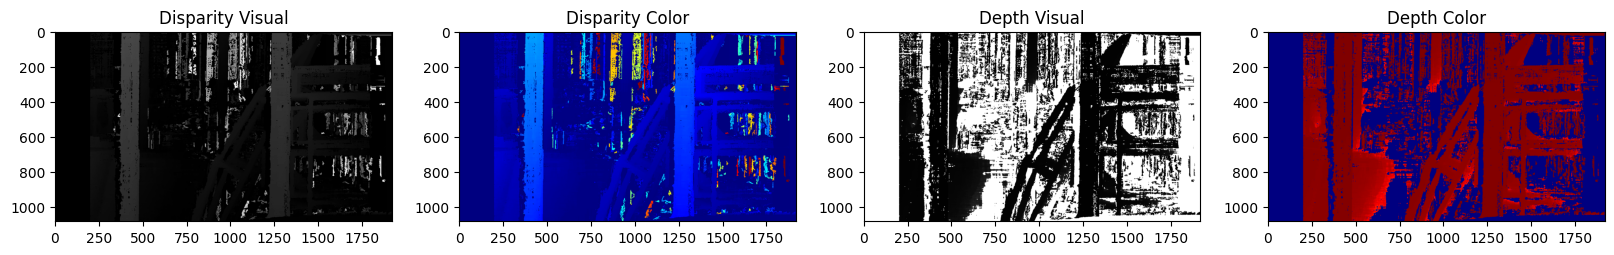

In [35]:

minDisparity = 0                                                                        #minimum disparity
numDisparities = 200                                                                 #number of disparities
blockSize = 5                                                                           #block size
disp12MaxDiff = 1                                                                       #maximum allowed difference in the left-right disparity check
uniquenessRatio = 10                                                                    #margin in percentage by which the match should be correct
speckleWindowSize = 100                                                                 #maximum size of smooth disparity regions to consider their noise speckles and invalidate
speckleRange = 32                                                                       #maximum disparity variation within each connected component
preFilterCap = 63                                                                       #truncation value for the prefiltered image pixels
P1 = 8*3*blockSize**2                                                                   #P1 = 8*3*blockSize**2
P2 = 32*3*blockSize**2                                                                  #P2 = 32*3*blockSize**2

stereo = cv2.StereoSGBM_create(minDisparity=minDisparity,                               #creating the StereoSGBM object
                               numDisparities=numDisparities,                           #setting the parameters
                               blockSize=blockSize,
                               P1=P1, P2=P2,
                               disp12MaxDiff=disp12MaxDiff,
                               uniquenessRatio=uniquenessRatio,
                               speckleWindowSize=speckleWindowSize,
                               speckleRange=speckleRange,
                               preFilterCap=preFilterCap,
                               mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)                    #setting the mode

disparity = stereo.compute(img1_r, img2_r).astype(np.float32) / 16.0                                  #computing the disparity
disparity_visual = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)      #normalizing the disparity
disparity_color = cv2.applyColorMap(disparity_visual, cv2.COLORMAP_JET)                                               #applying the color map




focal_length = params['cam0'][0, 0]                                                       #focal length
baseline = params['baseline']                                                             #baseline
disparity[disparity == 0] = 0.1                                                           #setting the disparity to 0.1
disparity[disparity == -1] = 0.1                                                          #setting the disparity to 0.1
depth = np.divide(focal_length * baseline, disparity)                                     #calculating the depth
depth_visual = cv2.normalize(depth, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)             #normalizing the depth
depth_color = cv2.applyColorMap(depth_visual, cv2.COLORMAP_JET)                           #applying the color map

cv2.imwrite("disparity_grayscale_traproom.png", disparity_visual)                             #saving the images
cv2.imwrite("disparity_map_traproom.png", disparity_color)
cv2.imwrite('depth_grayscale_traproom.png', depth_visual)
cv2.imwrite('depth_color_traproom.png', depth_color)

# cv2.imwrite("disparity_grayscale_classroom.png", disparity_visual)                             #saving the images
# cv2.imwrite("disparity_map_classroom.png", disparity_color)
# cv2.imwrite('depth_grayscale_classroom.png', depth_visual)
# cv2.imwrite('depth_color_classroom.png', depth_color)

# cv2.imwrite("disparity_grayscale_storageroom.png", disparity_visual)                             #saving the images
# cv2.imwrite("disparity_map_storageroom.png", disparity_color)
# cv2.imwrite('depth_grayscale_storageroom.png', depth_visual)
# cv2.imwrite('depth_color_storageroom.png', depth_color)

plt.figure(figsize=(20, 10))                                                               #plotting the images
plt.subplot(1, 4, 1)
plt.imshow(disparity_visual, cmap='gray')
plt.title('Disparity Visual')
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(disparity_color, cv2.COLOR_BGR2RGB))
plt.title('Disparity Color')
plt.subplot(1, 4, 3)
plt.imshow(depth_visual, cmap='gray')
plt.title('Depth Visual')
plt.subplot(1, 4, 4)
plt.imshow(depth_color)
plt.title('Depth Color')
plt.show()
